Escribe tu nombre y Clave

Nombre: 
 
Clave:  

# Recomendacion de Modelo de Default Para Banco

El objetivo de este proyecto es entrenar un modelo y recomendar al banco como utilizarlo.  
Puedes agregar mas snippets, usar fuentes de internet, otras librerias, comentar con otras personas, pero asegurate de ser muy explicitx con tu explicacion. Imagina que este documento lo va a evaluar una persona tecnica y una persona no tecnica, por lo que tienes que ser muy cuidadosx con lo que dices pues tiene que ser verdad y no tener errores metodologicos, pero tambien partes que sean faciles de leer.

1. Deberas replicar el analisis/codigo que utilizamos en el `AutoML` coun autogluon (o con cualquier otra libreria que desees), pero tendras que elimar la columna que especifica la `tasa de interes` o columnas equivalentes.  
   
2. Debes elegir (entrenar) dos modelo que no tenga `leakage`, que sean estadisticamente robustos y utiles para la operacion. Debes explicar de manera detallada con graficas, tablas y palabras por que propones el uso de cada modelo
   1. El primer modelo debe ser explicable (por regulacion debes ser capaz de explicar por que no se da el prestamo). Ofrece una guia para explicar como podria defenderse el banco con el modelo que promones
   2. El segundo debe ser elegido sin importar si es explicable o no  
   
3. Finalmente usando uno de los modelos anteriores (elige el que quieras) debes proponer al banco que tasa de interes utilizar para los prestamos (basandose en la probabilidad del modelo) bajo los siguientes escenarios
   1. El banco no es adverso al riesgo y quiere saber cual es la minima tasa a la que deberia prestar para no perder o ganar dinero (Valor esperado del prestamo igual a cero)
   2. El banco es adverso al riesgo y busca la tasa para la cual el valor esperado del prestamo represente una ganancia de 1.5 sobre el prestamo (Valor esperado del prestamo 1.5)
   3. El banco quiere obtener 1.2 veces el valor del prestamo, pero quiere que por lo menos el 30% de los prestamos realizados sean pagados (en promedio o valor esperado) 

# Codigo para prediccion

En esta seccion deberas replicar el proceso de entramiento para los dos modelos (interpretable y no interpretable)  
+ Utiliza los mismos datos que usamos en el proyecto de AutoML
+ Recuerda que debes quitar todas las columnas que incluyan la tasa de interes en tu prediccion, pues deberas proponer la tasa de interes mas tarde

### ETL

In [ ]:
import os
import pandas as pd
from autogluon.tabular import TabularDataset, TabularPredictor
from sklearn.model_selection import (train_test_split, KFold, cross_val_score, 
GridSearchCV, StratifiedKFold)
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
import pandas as pd

file_path = 'loans_sampe_data.parquet'
loans = pd.read_parquet(file_path)

In [13]:
# Eliminar la columna de tasa de interés
if 'int_rate' in loans.columns:
    loans.drop('int_rate', axis=1, inplace=True)

In [ ]:
missing_percentages = loans.isnull().mean() * 100
# Mostrar solo las columnas con valores faltantes
missing_percentages = missing_percentages[missing_percentages > 0]
print(missing_percentages.sort_values(ascending=False))

In [ ]:
threshold = 90  # Por ejemplo, eliminar columnas con más del 50% de valores faltantes
columns_to_drop = missing_percentages[missing_percentages > threshold].index
loans.drop(columns=columns_to_drop, inplace=True)

# Imputación para variables numéricas y categóricas
for col in loans.columns:
    if loans[col].dtype == 'object':
        loans[col].fillna(loans[col].mode()[0], inplace=True)
    else:
        loans[col].fillna(loans[col].median(), inplace=True)

In [13]:
loans['charged_off'] = (loans['loan_status'] == 'Charged Off').apply(np.uint8)
loans.drop('loan_status', axis=1, inplace=True)

In [13]:
X_train, X_test, y_train, y_test = train_test_split(loans.drop('charged_off', axis=1), 
                                                    loans['charged_off'], 
                                                    test_size=0.2, 
                                                    random_state=42, 
                                                    stratify=loans['charged_off'])

In [ ]:
def convert_string_to_number(df):
    for col in df.columns:
        if df[col].dtype == 'object':
            # Verificar si la columna contiene algún número
            if df[col].str.contains('\d', regex=True).any():
                # Extraer solo los números y convertir a flotante
                df[col] = df[col].str.extract('(\d+)', expand=False).astype(float)
convert_string_to_number(X_train)
convert_string_to_number(X_test)

#ONE HOT ENCODING
X_train = pd.get_dummies(X_train)
X_test = pd.get_dummies(X_test)

X_train, X_test = X_train.align(X_test, join='left', axis=1, fill_value=0)
# Verificar si hay valores NaN y reemplazarlos
X_train.fillna(X_train.median(), inplace=True)
X_test.fillna(X_train.median(), inplace=True)  # Usar la mediana de X_train para mantener la consistencia

### EDA

In [18]:
X_train.describe()

,Unnamed: 0,id,loan_amnt,funded_amnt,funded_amnt_inv,installment,annual_inc,dti,delinq_2yrs,fico_range_low,...,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit
count,80000.000000,8.000000e+04,80000.000000,80000.000000,80000.000000,80000.000000,8.000000e+04,80000.000000,80000.000000,80000.000000,...,80000.000000,80000.000000,80000.000000,80000.000000,80000.000000,80000.000000,8.000000e+04,8.000000e+04,80000.000000,80000.000000
mean,50093.457588,3.029289e+07,14902.841562,14902.841562,14899.831562,437.832834,7.472356e+04,18.776147,0.346438,692.544000,...,0.092475,2.095250,94.288332,50.719440,0.127037,0.055750,1.721042e+05,5.051874e+04,21076.985613,41087.101812
std,28818.176312,4.748055e+06,8515.288936,8515.288936,8513.366126,244.775149,5.995689e+04,8.535601,0.909494,29.416356,...,0.482002,1.742603,8.437801,35.189041,0.374667,0.381535,1.778160e+05,4.759910e+04,21158.074438,42390.542233
min,0.000000,5.716700e+04,1000.000000,1000.000000,1000.000000,30.420000,4.000000e+03,0.000000,0.000000,660.000000,...,0.000000,0.000000,16.700000,0.000000,0.000000,0.000000,2.500000e+03,0.000000e+00,0.000000,0.000000
25%,25173.750000,2.735026e+07,8000.000000,8000.000000,8000.000000,261.877500,4.500000e+04,12.340000,0.000000,670.000000,...,0.000000,1.000000,91.700000,20.000000,0.000000,0.000000,4.878550e+04,2.175300e+04,7300.000000,14174.250000
50%,50086.500000,3.049583e+07,13100.000000,13100.000000,13100.000000,380.560000,6.400000e+04,18.230000,0.000000,685.000000,...,0.000000,2.000000,97.700000,50.000000,0.000000,0.000000,1.108215e+05,3.821800e+04,14500.000000,30856.000000
75%,75067.250000,3.437289e+07,20000.000000,20000.000000,20000.000000,573.812500,9.000000e+04,24.760000,0.000000,705.000000,...,0.000000,3.000000,100.000000,80.000000,0.000000,0.000000,2.478808e+05,6.326925e+04,27600.000000,55113.750000
max,99999.000000,3.809811e+07,35000.000000,35000.000000,35000.000000,1407.010000,7.500000e+06,39.990000,21.000000,845.000000,...,18.000000,26.000000,100.000000,100.000000,12.000000,18.000000,9.999999e+06,1.359090e+06,456200.000000,876963.000000


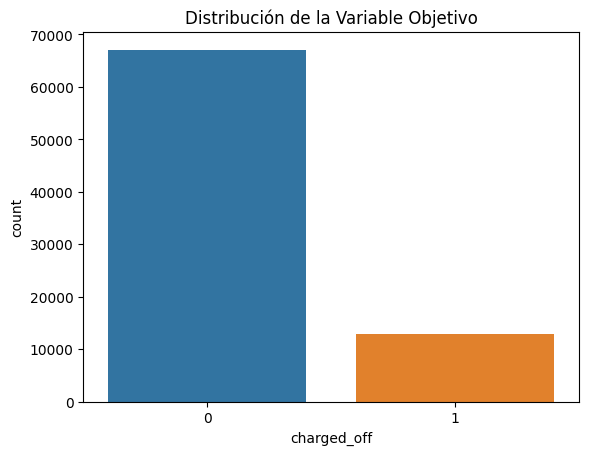

In [19]:
sns.countplot(x=y_train)
plt.title('Distribución de la Variable Objetivo')
plt.show()

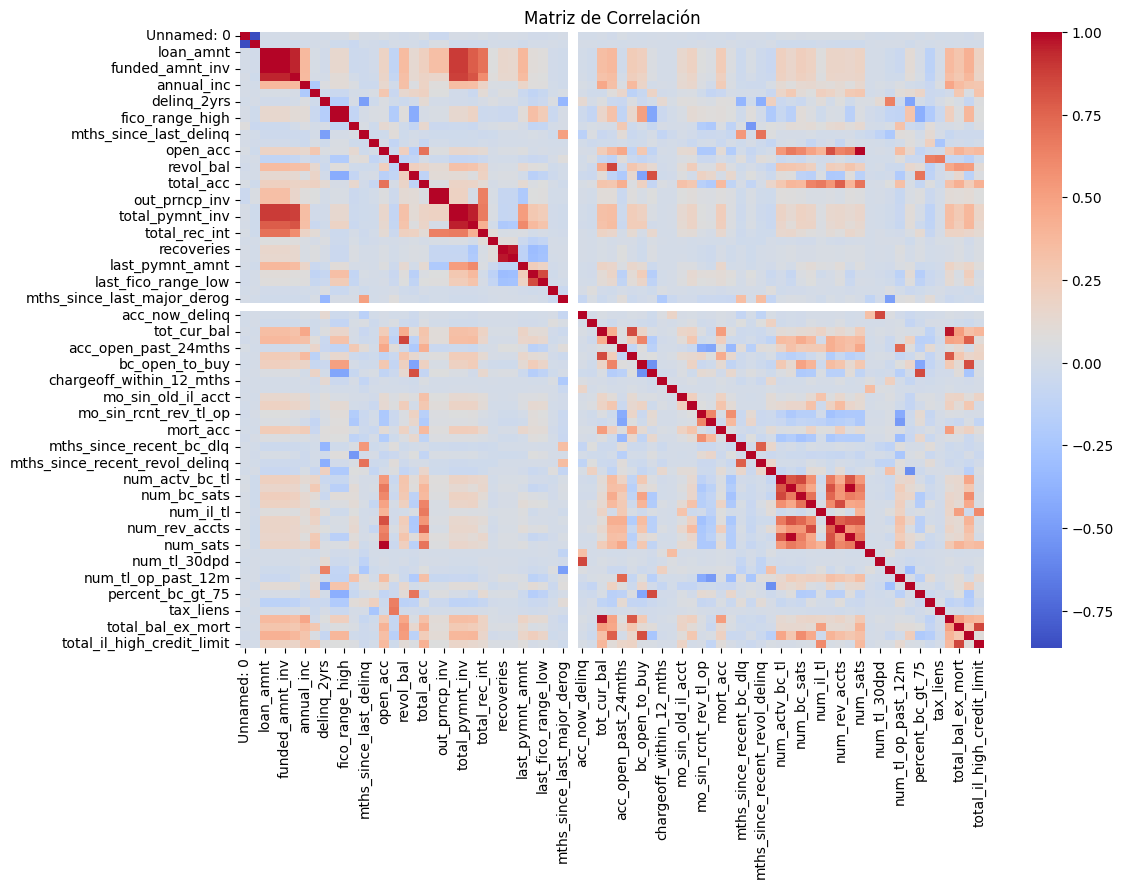

In [20]:
# Solo variables numEricas para la correlacion
numerical_features = X_train.select_dtypes(include=['int64', 'float64'])
corr_matrix = numerical_features.corr()

plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=False, cmap='coolwarm')
plt.title('Matriz de Correlación')
plt.show()

### Usaremos un arbol de decision para identificar la importancia de cada caracteristica

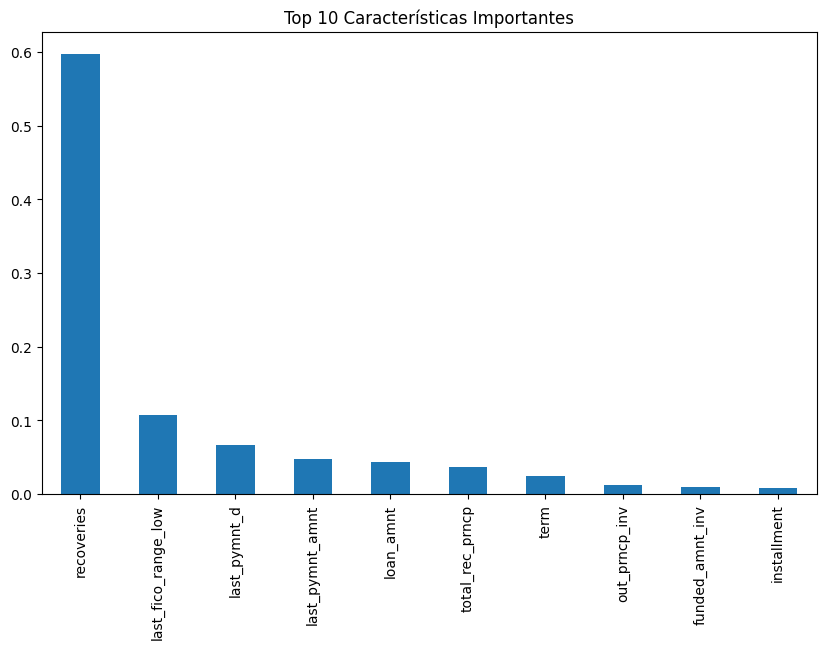

In [27]:
from sklearn.tree import DecisionTreeClassifier
tree_model = DecisionTreeClassifier(random_state=42)
tree_model.fit(X_train, y_train)

# Obtener la importancia de las características
feature_importances = pd.Series(tree_model.feature_importances_, index=X_train.columns)
feature_importances.sort_values(ascending=False, inplace=True)

# Visualizar las 10 características más importantes
plt.figure(figsize=(10, 6))
feature_importances[:10].plot(kind='bar')
plt.title('Top 10 Características Importantes')
plt.show()

### EDA Tasa de Interes

* Si las tasas de interés históricas son limitadas, los modelos pueden no ser capaces de generalizar bien a situaciones donde las tasas de interés varían significativamente.
* La falta de diversidad en las tasas de interés históricas podría hacer que sea arriesgado proponer tasas muy diferentes, ya que no se tendrían datos para respaldar el rendimiento del préstamo en estas nuevas condiciones.

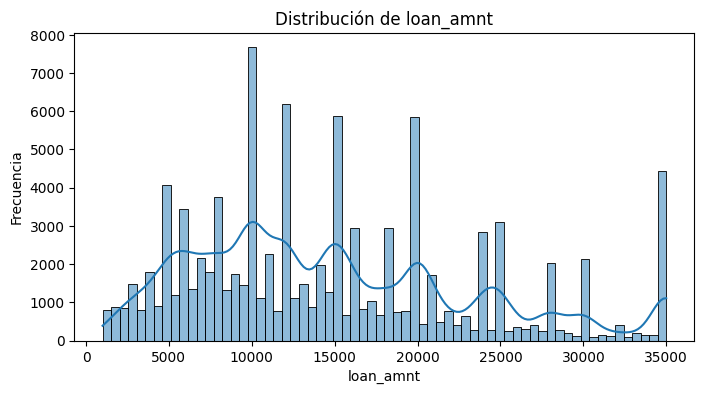

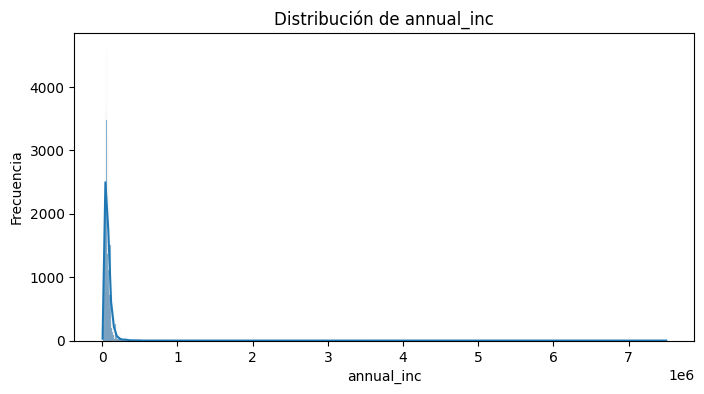

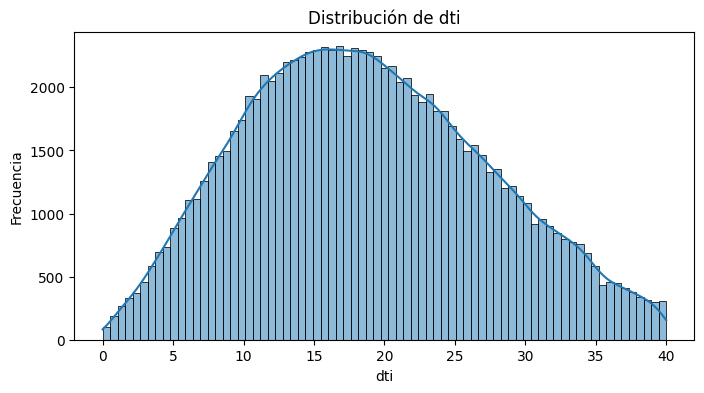

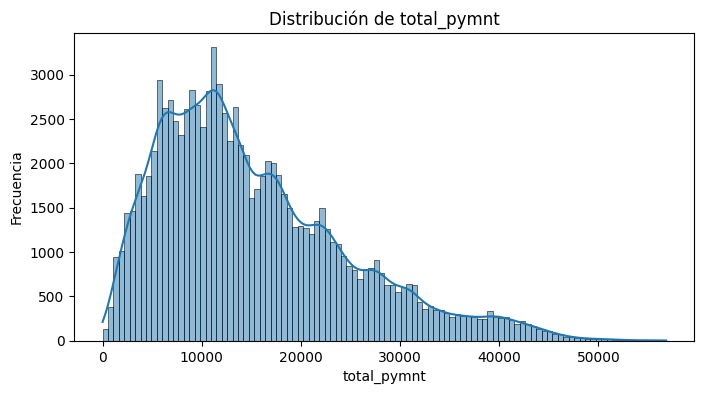

In [28]:
import matplotlib.pyplot as plt
import seaborn as sns

# Variables que podrían estar correlacionadas con la tasa de interés
variables_financieras = ['loan_amnt', 'annual_inc', 'dti', 'total_pymnt']  # Ejemplos de variables

for var in variables_financieras:
    plt.figure(figsize=(8, 4))
    sns.histplot(data=loans, x=var, kde=True)
    plt.title(f'Distribución de {var}')
    plt.xlabel(var)
    plt.ylabel('Frecuencia')
    plt.show()

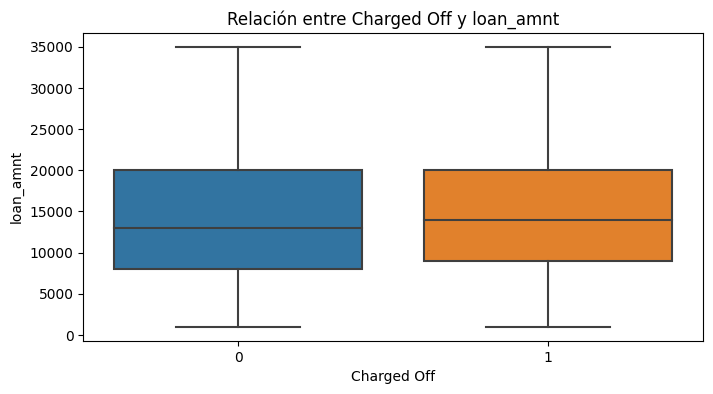

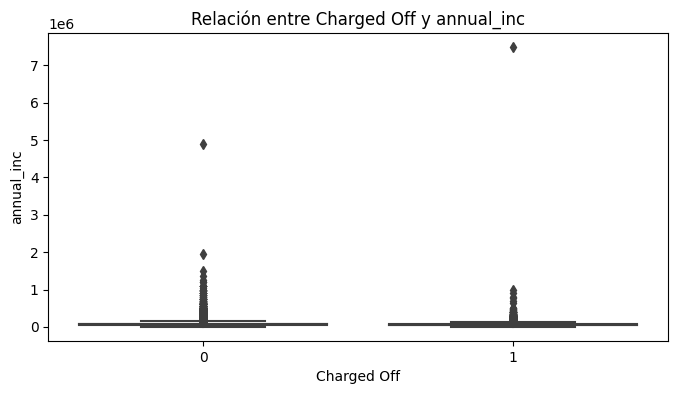

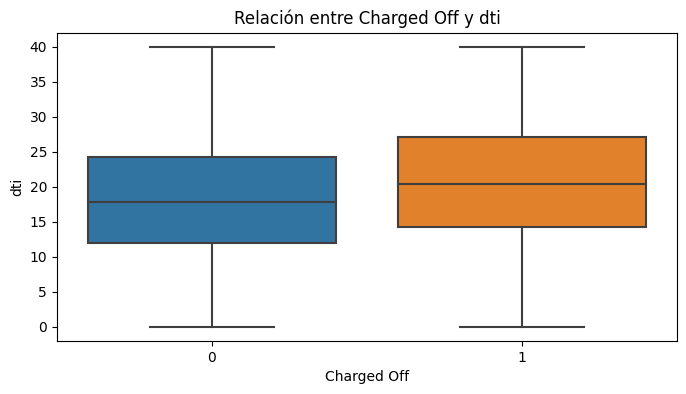

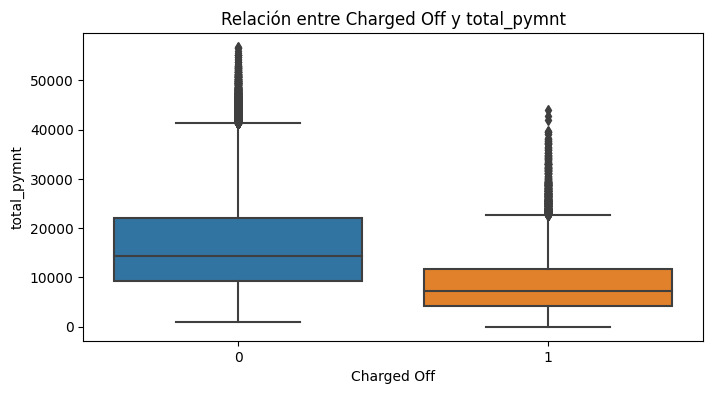

In [29]:
for var in variables_financieras:
    plt.figure(figsize=(8, 4))
    sns.boxplot(x='charged_off', y=var, data=loans)
    plt.title(f'Relación entre Charged Off y {var}')
    plt.xlabel('Charged Off')
    plt.ylabel(var)
    plt.show()

### Podemos usar métodos de clustering (como K-Means) en variables financieras para ver si se forman grupos naturales en los datos que podrían reflejar diferentes tasas de interés históricas.

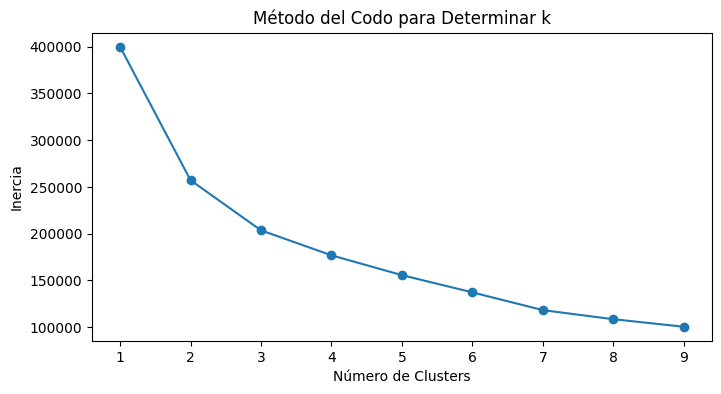

In [32]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

variables_cluster = ['loan_amnt', 'annual_inc', 'dti', 'total_pymnt']
data_cluster = loans[variables_cluster]
scaler = StandardScaler()
data_normalized = scaler.fit_transform(data_cluster)
inertia = []
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(data_normalized)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(8, 4))
plt.plot(range(1, 10), inertia, marker='o')
plt.title('Método del Codo para Determinar k')
plt.xlabel('Número de Clusters')
plt.ylabel('Inercia')
plt.show()

In [33]:
k = 3 #pudiera ser 4 o 5 incluso
kmeans = KMeans(n_clusters=k, random_state=42)
clusters = kmeans.fit_predict(data_normalized)
loans['Cluster'] = clusters
for i in range(k):
    cluster = loans[loans['Cluster'] == i]
    print(f"Cluster {i}:")
    print(cluster[variables_cluster].describe())

Cluster 0:
          loan_amnt     annual_inc           dti   total_pymnt
count  40488.000000   40488.000000  40488.000000  40488.000000
mean   10097.255977   67172.294357     12.521700  10170.042522
std     4676.680407   34237.795768      4.771367   4852.219225
min     1000.000000    4000.000000      0.000000      0.000000
25%     6000.000000   44000.000000      9.080000   6311.445408
50%    10000.000000   60000.000000     12.970000   9966.750000
75%    13700.000000   82000.000000     16.440000  13652.864645
max    31100.000000  480000.000000     23.400000  24458.955920
Cluster 1:
          loan_amnt     annual_inc           dti   total_pymnt
count  33006.000000   33006.000000  33006.000000  33006.000000
mean   11784.324062   53168.689663     27.324448  11345.780474
std     5426.970957   22334.100151      5.179151   5610.086052
min     1000.000000    4000.000000     18.320000      0.000000
25%     7900.000000   38000.000000     23.030000   6898.495001
50%    11837.500000   50000.00000

Asi, podemos analizar los 3 clusters:

### Cluster 0

* Montos de préstamo relativamente bajos, ingresos anuales moderados, y un DTI (Debt-to-Income Ratio) medio. Este clúster podría representar a prestatarios con necesidades financieras más bajas y perfiles de riesgo moderados. El DTI medio sugiere un equilibrio entre deudas y ingresos.

### Cluster 1
* Montos de préstamo medios, ingresos anuales más bajos y un DTI alto. Los prestatarios en este clúster podrían estar en una situación financiera más ajustada, con ingresos relativamente bajos y un nivel de endeudamiento más alto. Este grupo puede representar un riesgo crediticio más elevado.

### Cluster 2

* Montos de préstamo más altos, ingresos anuales sustancialmente más elevados, y un DTI medio-alto. Este clúster parece incluir prestatarios con una capacidad financiera significativa, reflejada en montos de préstamo más altos e ingresos anuales. Aunque el DTI es más alto que en el Cluster 0, los altos ingresos podrían compensar este riesgo.


La falta de información sobre la tasa de interés impide un análisis directo de cómo las tasas podrían haber afectado a estos grupos. Sin embargo, se pueden hacer algunas inferencias:

* Cluster 0 y 1: Es probable que estos grupos, especialmente el Cluster 1 con un DTI alto, hayan tenido tasas de interés más elevadas debido a un mayor riesgo percibido.
* Cluster 2: A pesar de montos de préstamo más altos, los altos ingresos podrían haber permitido a estos prestatarios acceder a tasas de interés más favorables.

## Seleccion/Propuesta de Modelo

Explica por que sugieres el modelo, por que es bueno, por que es malo, que metrica(s) usaste para elegirlo. Basicamente tienes que convencer al banco que tu modelo es bueno. Usa graficas, tablas, etc.

### Modelo Interpretable

### Árbol de Decisión

Los árboles de decisión son fáciles de interpretar y pueden manejar tanto características numéricas como categóricas.

In [30]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Crear y entrenar el modelo
dt_model = DecisionTreeClassifier(max_depth=5, random_state=42)  # Limitar la profundidad para simplificar la interpretación
dt_model.fit(X_train, y_train)

# Realizar predicciones en el conjunto de prueba
y_pred = dt_model.predict(X_test)

# Evaluar el modelo
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))


Accuracy: 0.9768

Classification Report:
               precision    recall  f1-score   support

           0       0.97      1.00      0.99     16769
           1       0.99      0.87      0.92      3231

    accuracy                           0.98     20000
   macro avg       0.98      0.93      0.95     20000
weighted avg       0.98      0.98      0.98     20000


Confusion Matrix:
 [[16741    28]
 [  436  2795]]


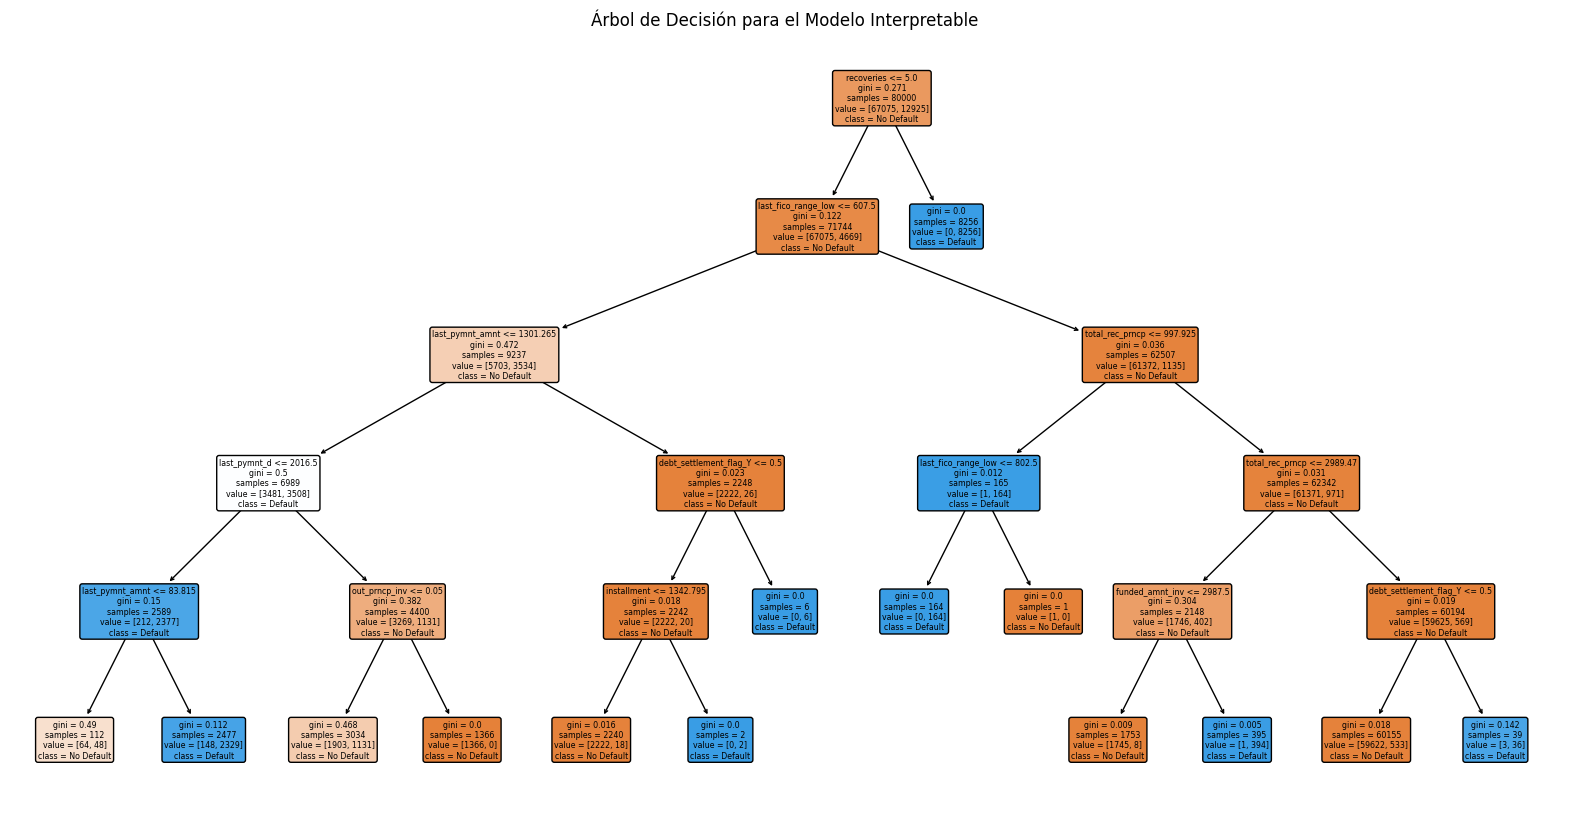

In [31]:
from sklearn.tree import plot_tree

plt.figure(figsize=(20,10))
plot_tree(dt_model, filled=True, feature_names=X_train.columns, class_names=['No Default', 'Default'], rounded=True)
plt.title("Árbol de Decisión para el Modelo Interpretable")
plt.show()

### Modelo no Interpretable

#### Gradient Boosting Machines (GBM)

* GBM es conocido por su capacidad para ofrecer una de las mejores precisiones en problemas de clasificación, especialmente en conjuntos de datos con características no lineales y complejas interacciones.
* Puede manejar eficientemente una mezcla de variables numéricas y categóricas.

Por otro lado, modelos como KNN, Random Forest (RF), árboles extremadamente aleatorizados (XT), regresión logística (LR), redes neuronales (NN) y FastAI se excluyen para enfocarse en GBM, que tiene una mayor capacidad de modelar interacciones complejas y patrones no lineales en los datos.

In [34]:
from autogluon.tabular import TabularPredictor

# Inicializar el predictor de AutoGluon
predictor = TabularPredictor(label='charged_off', eval_metric='accuracy').fit(
    train_data=X_train.join(y_train),
    presets='best_quality',  # Utiliza los mejores modelos y técnicas de ajuste de hiperparámetros
    excluded_model_types=['KNN', 'RF', 'XT', 'LR', 'NN', 'FASTAI']  # Excluye modelos más simples o interpretables
)

# Evaluación del modelo
performance = predictor.leaderboard(X_test.join(y_test), silent=True)
print(performance)

No path specified. Models will be saved in: "AutogluonModels\ag-20231126_061300\"
Presets specified: ['best_quality']
Stack configuration (auto_stack=True): num_stack_levels=0, num_bag_folds=8, num_bag_sets=1
	Consider setting `time_limit` to ensure training finishes within an expected duration or experiment with a small portion of `train_data` to identify an ideal `presets` and `hyperparameters` configuration.
Beginning AutoGluon training ...
AutoGluon will save models to "AutogluonModels\ag-20231126_061300\"
AutoGluon Version:  0.6.2
Python Version:     3.7.16
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.22621
Train Data Rows:    80000
Train Data Columns: 187
Label Column: charged_off
Preprocessing data ...
AutoGluon infers your prediction problem is: 'binary' (because only two unique label-values observed).
	2 unique label values:  [0, 1]
	If 'binary' is not the correct problem_type, please manually specify the problem_type parameter during predicto

                   model  score_test  score_val  pred_time_test  \
0        LightGBM_BAG_L1     0.99950   0.999162        0.990348   
1    WeightedEnsemble_L2     0.99950   0.999162        0.990348   
2         XGBoost_BAG_L1     0.99890   0.998563        1.663506   
3   LightGBMLarge_BAG_L1     0.99830   0.998188        1.469054   
4        CatBoost_BAG_L1     0.99820   0.997962        0.399871   
5  NeuralNetTorch_BAG_L1     0.99760   0.997225        4.051948   
6      LightGBMXT_BAG_L1     0.99725   0.997350        2.471253   

   pred_time_val    fit_time  pred_time_test_marginal  pred_time_val_marginal  \
0       2.345973   26.993270                 0.990348                2.345973   
1       2.536729   41.878790                 0.000000                0.190756   
2       1.780402   18.601530                 1.663506                1.780402   
3       3.281928   46.426665                 1.469054                3.281928   
4       0.243351  142.374825                 0.399871     

## Propuesta de tasa de interes

In [37]:
mejor_modelo = 'LightGBM_BAG_L1'
y_test_pred_proba = predictor.predict_proba(X_test, model=mejor_modelo)
probabilidades_impago = y_test_pred_proba.iloc[:, 1]

### Valor esperado del prestamo igual a cero

In [38]:
def valor_esperado_tasa_cero(df, proba_default, tasa_interes):
    ingreso_por_interes = df['loan_amnt'] * tasa_interes
    perdida_por_default = df['loan_amnt'] * proba_default

    valor_esperado = ingreso_por_interes - perdida_por_default
    return valor_esperado.mean()

In [40]:
tasas = np.linspace(0, 0.3, 300)  # Rango de tasas de interés a evaluar
for tasa in tasas:
    ve = valor_esperado_tasa_cero(X_test, probabilidades_impago, tasa)
    if np.isclose(ve, 0, atol=0.01):  # Aceptar una pequeña tolerancia
        print(f"Tasa de interés para valor esperado cero: {tasa:.3f}")
        break

### Valor esperado del prestamo igual a 1.5 

In [43]:
def valor_esperado_tasa_15(df, proba_default, tasa_interes):
    ingreso_por_interes = df['loan_amnt'] * (1.5 + tasa_interes)
    perdida_por_default = df['loan_amnt'] * proba_default

    valor_esperado = ingreso_por_interes - perdida_por_default
    return valor_esperado.mean()

tasas = np.linspace(0, 0.3, 300)
for tasa in tasas:
    ve = valor_esperado_tasa_15(X_test, probabilidades_impago, tasa)
    if np.isclose(ve, 1.5 * X_test['loan_amnt'].mean(), atol=0.01):
        print(f"Tasa de interés para valor esperado 1.5: {tasa:.3f}")
        break


### Valor esperado del prestamo 1.2 y default menor a 30%

In [42]:
def valor_esperado_tasa_12_menor_30(df, proba_default, tasa_interes):
    ingreso_por_interes = df['loan_amnt'] * (1.2 + tasa_interes)
    perdida_por_default = df['loan_amnt'] * proba_default

    valor_esperado = ingreso_por_interes - perdida_por_default
    tasa_default = np.mean(proba_default > 0.3)  # Proporción de defaults estimados mayor a 30%
    return valor_esperado.mean(), tasa_default

tasas = np.linspace(0, 0.3, 300)
for tasa in tasas:
    ve, tasa_default = valor_esperado_tasa_12_menor_30(X_test, probabilidades_impago, tasa)
    if np.isclose(ve, 1.2 * X_test['loan_amnt'].mean(), atol=0.01) and tasa_default < 0.3:
        print(f"Tasa de interés para valor esperado 1.2 con default menor a 30%: {tasa:.3f}")
        break


## Para pensar

### 1. Que pasaria con los modelos que propusiste, si resulta que la tasa de interes afecta la probabilidad de pago (lo cual es muy probable)?

* Sin considerar la tasa de interés, los modelos podrían no estar viendo toda la historia. Si las tasas altas hacen que la gente pague menos, o al revés, el modelo está perdiéndose de algo importante. Si no sabemos cómo la tasa de interés afecta los pagos, cualquier consejo que demos sobre qué tasa poner podría estar desencaminado.

### 2. Explica el problema que apareceria a las personas del banco para evitar problemas con tu modelo, si lo explicas mal te veras mal cuando falle.

Hay que ser directo con el banco:

* "Hay que tener en cuenta que nuestro modelo no incluye la tasa de interés, lo cual es un hueco importante. Esto significa que nuestras predicciones podrían no ser tan precisas como nos gustaría, especialmente en lo que respecta a cómo diferentes tasas de interés afectan el riesgo de impago. Dado que no hemos contemplado la tasa de interés, hay un riesgo de que el modelo no funcione tan bien en la vida real como esperamos. Podríamos estar subestimando o sobreestimando el riesgo en ciertos tipos de préstamos."


### 3. Como podrias solucionarlo (piensa si basta con agregar la tasa de interes y sobre la causalidad y correlacion)

* Agregar la Tasa de Interés al Modelo: La solución más obvia es incluir la tasa de interés como parte del modelo. Esto nos daría una mejor idea de cómo afecta al riesgo de impago.
* Entender la Relación Real: Necesitamos averiguar si la tasa de interés realmente causa cambios en los pagos, y en que medida

Una vez que tengamos la tasa de interés en el modelo, debemos estar listos para hacer ajustes según sea necesario, especialmente si las condiciones del mercado o el comportamiento de los clientes cambian.